In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import torch
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, default_data_collator, pipeline
from datasets import Dataset, ClassLabel
# Dataset : https://www.kaggle.com/datasets/tobiasbueck/multilingual-customer-support-tickets -> But we use the Engish only

### 1. Preparing the Dataset

In [2]:
df = pd.read_csv("English_Dataset_Clean.csv",index_col = 0)
df = df.loc[df["subject"].notna()]  
df.head(2)

,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN


In [3]:
def combineSubBody(x) : 
    body = x["body"]
    result = f"{body.lower()}"
    return result
df["content"] = df.apply(combineSubBody,axis = 1)

In [4]:
LABELENCODER = LabelEncoder()
df["labels"] = LABELENCODER.fit_transform(df["queue"])
df_selected = df.iloc[:,-2:]

In [5]:
df_selected

,content,labels
1,"dear customer support team,\n\ni am writing to...",9
2,"dear customer support team,\n\ni hope this mes...",6
3,"dear customer support team,\n\ni hope this mes...",0
4,"dear support team,\n\ni hope this message reac...",7
5,"dear customer support,\n\ni hope this message ...",9
...,...,...
28578,an unexpected billing discrepancy has been not...,0
28580,"a data breach has occurred, which might be rel...",5
28582,the data analytics tool experiences sluggish p...,9
28585,requesting an update on the integration featur...,4


### 2. Import the Model and Prepare Model

In [6]:
device = "cpu"
if torch.cuda.is_available() : 
    device = "cuda"

In [7]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 10)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
dataset = Dataset.from_pandas(df_selected)
dataset = dataset.remove_columns("__index_level_0__")
dataset = dataset.cast_column("labels", ClassLabel(num_classes = 10))
dataset_splitted = dataset.train_test_split(test_size = 0.1, stratify_by_column= "labels")

Casting the dataset: 100%|██████████| 13729/13729 [00:00<00:00, 1655747.88 examples/s]


In [9]:
def tokenization(batch) : 
    return tokenizer(batch["content"], padding = "max_length", max_length = 512, truncation = True, return_tensors = "pt")

In [10]:
dataset_splitted_tokenized = dataset_splitted.map(tokenization, batched = True, batch_size = 16)

Map: 100%|██████████| 1373/1373 [00:02<00:00, 549.63 examples/s]


In [11]:
dataset_splitted_tokenized.set_format("torch",['input_ids', 'token_type_ids', 'attention_mask',"labels"])

### 3. Prepare the Trainer and Method Needed [USE BERT Model] => Without PreProcessing

In [12]:
acc_score = evaluate.load("accuracy")
def comp_fn(x) : 
    logits, label = x
    hasil = np.argmax(logits, axis = -1)
    return acc_score.compute(predictions = hasil, references = label)

In [13]:
trainingArguments = TrainingArguments(
    output_dir = "./queue-classification",
    do_train = True,
    do_eval = True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=5,
    eval_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16 = True,
    weight_decay=0.01,
    lr_scheduler_type="cosine"
)

In [14]:
trainer = Trainer(
    args = trainingArguments,
    model = model,
    tokenizer = tokenizer,
    data_collator=default_data_collator,
    compute_metrics = comp_fn,
    train_dataset = dataset_splitted_tokenized["train"],
    eval_dataset=dataset_splitted_tokenized["test"]
)

C:\Users\Reynaldi\AppData\Local\Temp\ipykernel_5696\4286729834.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
trainer.train()
trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy
500,1.763000,1.632982,0.404953
1000,1.585500,1.558504,0.438456
1500,1.457800,1.462597,0.478514
2000,1.241000,1.407912,0.508376
2500,1.103200,1.394844,0.536052
3000,0.968700,1.366016,0.559359
3500,0.855200,1.360106,0.571012


{'eval_loss': 1.3601059913635254,
 'eval_accuracy': 0.5710123816460306,
 'eval_runtime': 7.9669,
 'eval_samples_per_second': 172.338,
 'eval_steps_per_second': 21.589,
 'epoch': 5.0}

### 4. Prepare the Data for Solution of Bad Accuracy

In [31]:
df_new = df.iloc[:,:-1]
df_new.head(2)

,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,content
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN,"dear customer support team,\n\ni am writing to..."
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN,"dear customer support team,\n\ni hope this mes..."


In [32]:
top_queues = [
    'Technical Support', 'Product Support', 'Customer Service', 
    'IT Support']

In [33]:
def make_other(x) : 
    if x in top_queues :
        return x 
    return "others"
df_new["label_with_other"] = df["queue"].apply(make_other)

In [34]:
df_new = df_new[["content","label_with_other"]]
df_new.head(3)

,content,label_with_other
1,"dear customer support team,\n\ni am writing to...",Technical Support
2,"dear customer support team,\n\ni hope this mes...",others
3,"dear customer support team,\n\ni hope this mes...",others


In [35]:
df_new["labels"] = LABELENCODER.fit_transform(df_new["label_with_other"])

In [36]:
dataset = Dataset.from_pandas(df_new)
dataset = dataset.remove_columns("__index_level_0__")
dataset = dataset.cast_column("labels", ClassLabel(names = [0,1,2,3,4]))
dataset_splitted = dataset.train_test_split(test_size = 0.1, stratify_by_column= "labels")

Casting the dataset: 100%|██████████| 13729/13729 [00:00<00:00, 1463741.73 examples/s]


### 5. Prepare the Trainer and Method Needed [USE BERT Model] => With Logical Solution

In [37]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
dataset_splitted_tokenized = dataset_splitted.map(tokenization, batched = True, batch_size = 16)

Map: 100%|██████████| 1373/1373 [00:02<00:00, 500.24 examples/s]


In [39]:
dataset_splitted_tokenized.set_format("torch",['input_ids', 'token_type_ids', 'attention_mask',"labels"])

In [40]:
acc_score = evaluate.load("accuracy")
def comp_fn(x) : 
    logits, label = x
    hasil = np.argmax(logits, axis = -1)
    return acc_score.compute(predictions = hasil, references = label)

In [41]:
trainingArguments = TrainingArguments(
    do_train = True,
    do_eval = True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=5,
    eval_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16 = True,
    weight_decay=0.01,
    lr_scheduler_type="cosine"
)

In [42]:
trainer = Trainer(
    args = trainingArguments,
    model = model,
    tokenizer = tokenizer,
    data_collator=default_data_collator,
    compute_metrics = comp_fn,
    train_dataset = dataset_splitted_tokenized["train"],
    eval_dataset=dataset_splitted_tokenized["test"]
)

C:\Users\Reynaldi\AppData\Local\Temp\ipykernel_5696\4286729834.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [43]:
trainer.train()
trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy
500,1.438500,1.357294,0.426074
1000,1.317000,1.305262,0.440641
1500,1.229100,1.238262,0.479971
2000,1.051800,1.203814,0.537509
2500,0.908700,1.232961,0.546977
3000,0.775300,1.180232,0.582666
3500,0.695400,1.189860,0.586307


{'eval_loss': 1.189860224723816,
 'eval_accuracy': 0.5863073561544064,
 'eval_runtime': 8.012,
 'eval_samples_per_second': 171.369,
 'eval_steps_per_second': 21.468,
 'epoch': 5.0}

In [44]:
trainer.save_model("queue_classification")

### 4. Check Pipeline

In [46]:
pipe = pipeline(task = "text-classification", model = "./queue_classification")
result = []
for pred in pipe(dataset_splitted["test"]["content"][:]) : 
    result.append(int(pred["label"].split("_")[-1]))

Device set to use cuda:0


In [49]:
label = LABELENCODER.inverse_transform([0,1,2,3,4])

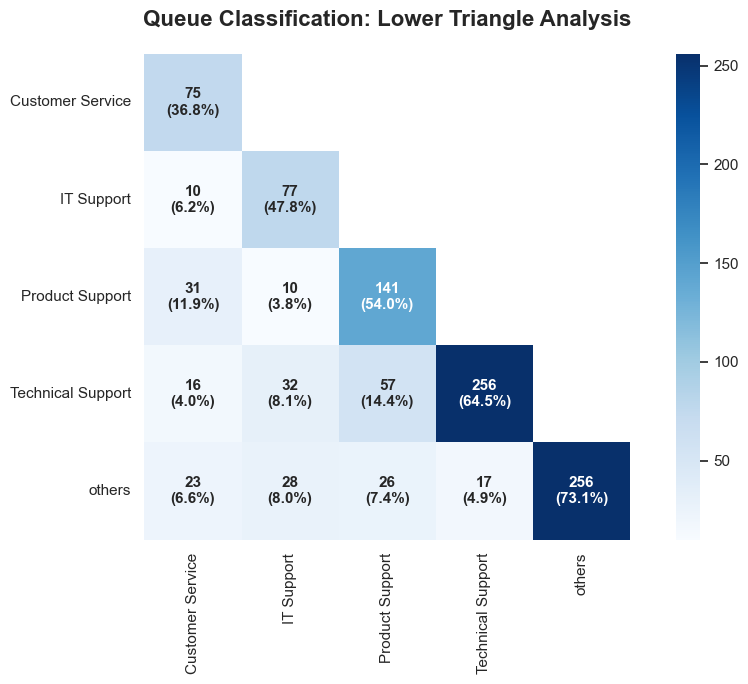

In [53]:
# 1. Hitung Confusion Matrix dan Persentase
cm = confusion_matrix(y_true=dataset_splitted["test"]["labels"][:], y_pred=result)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 2. Buat label gabungan "Jumlah (Persen)"
labels = [f"{count}\n({percent:.1%})" for count, percent in zip(cm.flatten(), cm_percent.flatten())]
labels = np.asarray(labels).reshape(cm.shape)

# 3. Buat Mask untuk menyembunyikan bagian atas (di atas diagonal)
# np.triu (triangle upper) akan mengambil bagian atas, k=1 artinya dimulai tepat di atas diagonal
mask = np.triu(np.ones_like(cm, dtype=bool), k=1)

# 4. Visualisasi Profesional
plt.figure(figsize=(10, 7))
sns.set_theme(style="white")

ax = sns.heatmap(
    cm, 
    mask=mask,          
    annot=labels,      
    fmt="", 
    cmap="Blues", 
    yticklabels=label, 
    xticklabels=label,
    annot_kws={"size": 11, "weight": "bold"},
    square=True        
)

# 5. Styling
plt.title("Queue Classification: Lower Triangle Analysis", fontsize=16, pad=20, weight='bold')

plt.tight_layout()
plt.show()